# Making sure Metropolis-Hastings works

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import tqdm
import pickle
import os
import h5py
from sklearn.metrics import mutual_info_score
from numba.typed import List
from numba import njit,prange,jit
import sys
sys.path.append('/Users/mariayuffa/semester-project-II')
from utils import *
from trad_methods import *

print("The directory is the follows:", os.getcwd())

The directory is the follows: /Users/mariayuffa/semester-project-1


# Metropolis-Hastings algorithm
- The magnetization needs to be plotted in terms of accepted states

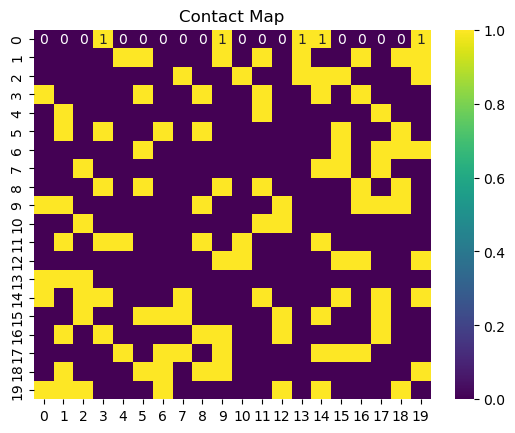

In [2]:
def energy(sequence, J):
    """
    Calculate the Hamiltonian of the sequence.
    Args:
        sequence (np.array): The current sequence of spins.
        J (np.array): Interaction matrix.
    Returns:
        float: The energy of the current sequence.
    """
    #return -np.sum(J * np.outer(sequence, sequence))
    return (-1)*np.matmul(sequence,np.matmul(J,sequence))

def set_interaction_mat(n, prob=[0.7,0.3]):
    # Create an upper triangular matrix with random 0s and 1s
    upper_tri = np.triu(np.random.choice([0, 1], size=(n, n), p=prob), 1)
    # Create the symmetric matrix by adding the upper triangular and its transpose
    symmetric_matrix = upper_tri + upper_tri.T
    # Ensure the diagonal is zero (as commonly expected in adjacency matrices, etc.)
    np.fill_diagonal(symmetric_matrix, 0)
    return symmetric_matrix

# Example usage:
n = 20  # Size of the matrix
J = set_interaction_mat(n)
sns.heatmap(J, cmap='viridis', annot=True)
plt.title('Contact Map')
plt.show()

## Spin flipping

In [99]:
def propose_sequence(current_sequence, temp=1.0, with_T_varied=True):
    """
    Propose a new sequence by flipping a set number of spins.
    Args:
        current_sequence (np.array): The current sequence of spins.
        num_of_flips (int): Number of spins to flip.
        temp (int): Temperature
        with_T_varied (bool): adapts the algorithm to the one that is dependent on Temperature rather than number of flips
    Returns:
        np.array: The proposed sequence of spins.
    """
    new_sequence = current_sequence.copy()
    #if with_T_varied==False:
    #    flip_indices = np.random.choice(len(new_sequence), num_of_flips, replace=False)
    #else:
    #    flip_indices = np.random.uniform(0, 1, size=len(new_sequence)) < np.exp(-2/temp)
    #flip_indices = np.random.uniform(0, 1, size=num_of_flips) < prob
    #new_sequence[flip_indices] = -new_sequence[flip_indices]
    #flip_indices = np.random.uniform(0, 1, size=len(new_sequence)) < np.exp(-2/temp)
    flip_indices = np.random.choice(len(new_sequence), 1, replace=False)
    new_sequence[flip_indices] *= -1
    return new_sequence


def metropolis_hastings_spin(J, initial_sequences, T=1.0, num_of_flips=5):
    """
    Perform the Metropolis-Hastings algorithm on multiple sequences.
    Args:
        J (np.array): Interaction matrix.
        initial_sequences (list of np.array): Initial sequences of spins.
        num_iterations (int): Number of iterations to perform.
        T (float): Temperature.
        num_of_flips (int): Number of spins to flip in each proposal.
        with_T_varied (bool): adapts the algorithm to the one that is dependent on Temperature rather than number of flips
    Returns:
        list of np.array: Final sequences after iterations.
    """
    current_sequences = initial_sequences.copy()
    log_sequences = np.zeros((len(current_sequences), num_of_flips))
    accepted_states = np.zeros(len(current_sequences))
    for j in tqdm.tqdm(range(len(current_sequences))):
        for i in range(num_of_flips):
            proposed_sequence = propose_sequence(current_sequences[j].copy(), temp=T)
            current_energy = energy(current_sequences[j].copy(), J)
            proposed_energy = energy(proposed_sequence, J)
            energy_difference = proposed_energy - current_energy
            if (energy_difference < 0):
                current_sequences[j] = proposed_sequence
                accepted_states[j]+=1
                # if in the proposed sequence we already consider the temperature (higher temperature more flips)
                # there is no utility in considering the else clause
            
            else:
                if np.random.uniform(0,1)<np.exp(-energy_difference/T):
                    current_sequences[j] = proposed_sequence
                    accepted_states[j]+=1
            log_sequences[j,i] = np.absolute(np.sum(current_sequences[j]))/len(current_sequences[j])
    return current_sequences, log_sequences, accepted_states

# Example usage:
np.random.seed(42)  # For reproducibility

size = 200  # Size of each sequence
num_sequences = 2048  # Number of sequences
num_of_flips = 1000  # Number of spins to flip in each proposal

#J = mat_contact
#np.save("data/contact_mat/J_real", J)
#J = np.array(matrix['PF00072']['contact_mask'].astype(int))
#J = np.load("data/contact_mat/J_example.npy")
J = set_interaction_mat(size, prob=[0.98,0.02])
initial_sequences = [np.random.choice([-1, 1], size=size) for _ in range(num_sequences)]

final_sequences_train, log_sequences, accepted_states = metropolis_hastings_spin(J, initial_sequences, T=5, num_of_flips=num_of_flips)
# Final_sequences contains the sequences after they have potentially reached their stable states

final_chains_train = np.array(final_sequences_train)
initial_chains = np.array(initial_sequences)
print("Number of chains:",final_chains_train.shape[0])
print("Number of spins in the chain:",final_chains_train.shape[1])


100%|██████████| 2048/2048 [01:44<00:00, 19.60it/s]

Number of chains: 2048
Number of spins in the chain: 200


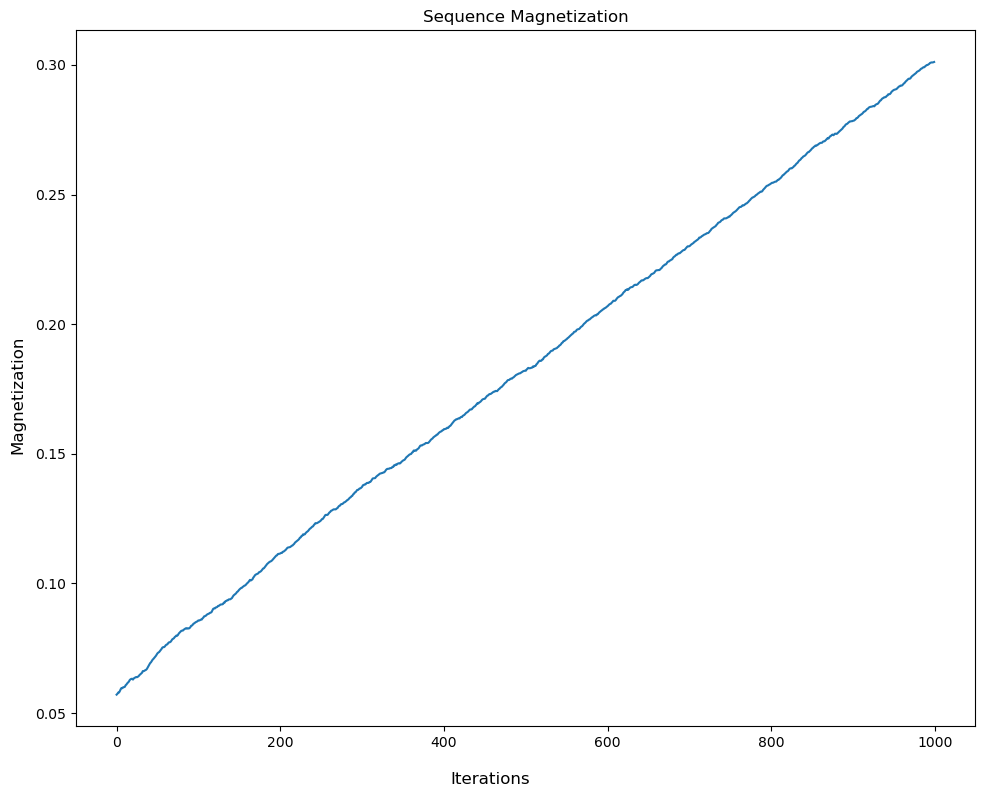

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.plot(np.arange(num_of_flips), log_sequences.mean(axis=0), label="Mean Magnetization")
ax.set_title("Sequence Magnetization")
fig.supxlabel("Iterations")
fig.supylabel("Magnetization")
plt.tight_layout()
plt.show()

100%|██████████| 2048/2048 [01:43<00:00, 19.82it/s]


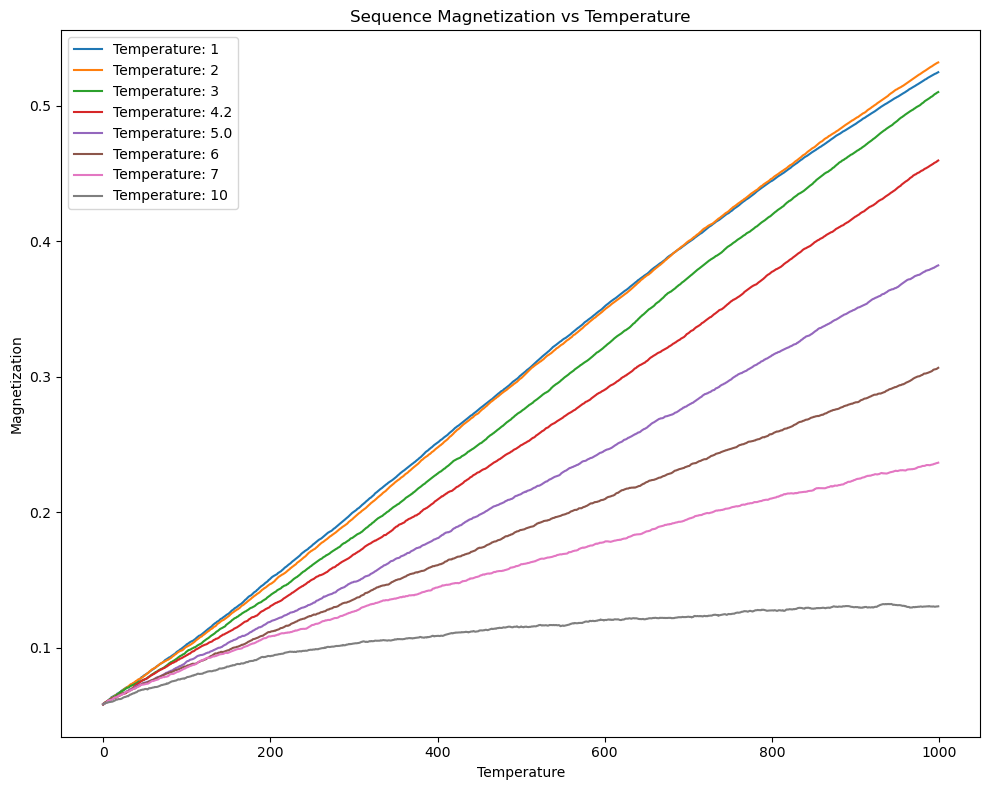

In [107]:
def plot_mag_vs_temp(J, initial_sequences, num_of_flips, temp_list):
    plt.figure(figsize=(10,8))
    for i in range(len(temp_list)):
        __, log_sequences,__ = metropolis_hastings_spin(J, initial_sequences, T=temp_list[i], num_of_flips=num_of_flips)
        plt.plot(np.arange(num_of_flips), log_sequences.mean(axis=0), label=f"Temperature: {temp_list[i]}")
    plt.legend()
    plt.title("Sequence Magnetization vs Temperature")
    plt.xlabel("Temperature")
    plt.ylabel("Magnetization")
    plt.tight_layout()
    plt.show()

J = set_interaction_mat(size, prob=[0.98,0.02])
initial_sequences = [np.random.choice([-1, 1], size=size) for _ in range(num_sequences)]
temp_list = [1, 2, 3, 4.2, 5.0, 6, 7, 10]
plot_mag_vs_temp(J, initial_sequences, num_of_flips, temp_list)

## Cluster Flipping

In [271]:
def FindNeighbors(edge_site, J, current_sequence):
    """
    Computes every neighbouring sites of the edge site

    Parameters
    ----------
    edge_site : int
        site number in graph
    tmp_matcontact : 2darray
        adjacency matrix of the graph
    nbrspin : int
        number of sites/nodes in graph

    Returns
    -------
    list_neighbors_site : List
        provides a list of ints corresponding to the neighbouring sites

    """
    list_neighbours_site = []
    for l in range(0,edge_site):
        if J[l, edge_site] == 1:
            list_neighbours_site.append(l)
            
    for k in range(edge_site+1, len(current_sequence)):
        if J[edge_site,k] == 1:
            list_neighbours_site.append(k)
            
    return list_neighbours_site

def ClusterIsing(current_sequence, list_neighbours, T):
    """
    Algorithm to make one flip in a sequence

    Parameters
    ----------
    nbrspin : int
        number of sites/nodes in graph.
    list_neighbours : List
        List of neighbours, for each key (= one site) it stores a list of neighbours
    tmp_chain : 1d array
        starting sequence .
    p : float
        probability accepting a site in cluster.

    Returns
    -------
    tmp_chain : 1d array
        sequence after cluster flip.

    """
    seq = current_sequence.copy()
    # select randomly the starting site from which the cluster is built
    start_site = np.random.randint(0, len(current_sequence))
    # create the list which contain all sites in the cluster
    cluster = []
    # create the list which contains the sites newly added to explore the 
    # neighbors of them to expand the cluster
    pocket = []
    # contains all the sites forming the cluster
    cluster.append(start_site)
    # contains all the sites which are on the edge of the cluster
    pocket.append(start_site)
    # define a variable containing the spin orientation of the cluster 1 or -1
    spin_orientation = seq[start_site] 

    p = 1 - np.exp(-2/T) # 1-np.exp(-2/T) # probability of accepting a site in the cluster
 
    # as long as the cluster is not empty the loop continues
    while pocket:
        # choose one element in the pocket list containing edge sites
        pocket_site = np.random.choice(np.array(pocket))
        for site in list_neighbours[pocket_site]:
            # if the site is not in the cluster and the spin orientation is the same
            if (site not in cluster) and (seq[site] == spin_orientation) and (np.random.uniform(0.0,1.0)<p):
                pocket.append(site)
                cluster.append(site)

        pocket.remove(pocket_site)

    for elem in cluster:
            seq[elem] = seq[elem]*(-1)
    return seq

def ConvertDictList(Neighbors_dict):
    """
    function to convert the neighbouring dict into a list in order to use numba
    """
    list_neighbors = List()
    
    for key in Neighbors_dict.keys():
        tmplist = List([-1]+Neighbors_dict[key])
        list_neighbors.append(tmplist[1:])
    return list_neighbors

def metropolis_hastings_cluster(J, initial_sequences, flip_cluster, T=5.0):
    """
    Perform the Metropolis-Hastings algorithm on multiple sequences.
    Args:
        J (np.array): Interaction matrix.
        initial_sequences (list of np.array): Initial sequences of spins.
        num_iterations (int): Number of iterations to perform.
        T (float): Temperature.
        num_of_flips (int): Number of spins to flip in each proposal.
    Returns:
        list of np.array: Final sequences after iterations.
    """
    current_sequences = initial_sequences.copy()
    log_sequences = np.zeros((len(current_sequences), flip_cluster+1))
    log_sequences[:,0] = np.abs(np.sum(current_sequences, axis=1))/len(current_sequences[0])
    accepted_states = np.zeros(len(current_sequences))
    Neighbors_dict = {site: FindNeighbors(site, J, current_sequences[0]) for site in range(0,len(current_sequences[0]))}
    list_neighbours = ConvertDictList(Neighbors_dict)
    
    #for n in tqdm.tqdm((range(num_iters))):
    for i in tqdm.tqdm(range(len(current_sequences))):
        tau = 0
        proposed_sequence = current_sequences[i].copy()
        #print("current sequence", np.abs(np.sum(current_sequences[i])))
        while tau < flip_cluster:
            proposed_sequence = ClusterIsing(proposed_sequence, list_neighbours, T)
            log_sequences[i,tau+1] = np.abs(np.sum(proposed_sequence))/len(proposed_sequence)
            tau += 1

        current_sequences[i] = proposed_sequence
    return current_sequences, log_sequences, accepted_states

# Example usage:
np.random.seed(42)  # For reproducibility

size = 200  # Size of each sequence
num_sequences = 200 # Number of sequences
flip_cluster = 300
#np.save(f'data/data_enc.npy', np.stack(all_enc_seq))

#J = mat_contact
#np.save("data/contact_mat/J_real", J)
#J = np.array(matrix['PF00072']['contact_mask'].astype(int))
#J = np.load("data/contact_mat/J_example.npy")
J = set_interaction_mat(size, prob=[0.98,0.02])
np.save("data/contact_mat/J_large", J)
initial_sequences = [np.random.choice([-1, 1], size=size) for _ in range(num_sequences)]

final_sequences_train, log_sequences, accepted_states = metropolis_hastings_cluster(J, initial_sequences, flip_cluster=flip_cluster, T=3)
# Final_sequences contains the sequences after they have potentially reached their stable states

final_chains_train = np.array(final_sequences_train)
initial_chains = np.array(initial_sequences)
print("Number of chains:",final_chains_train.shape[0])
print("Number of spins in the chain:",final_chains_train.shape[1])


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [01:22<00:00,  2.42it/s]

Number of chains: 200
Number of spins in the chain: 200


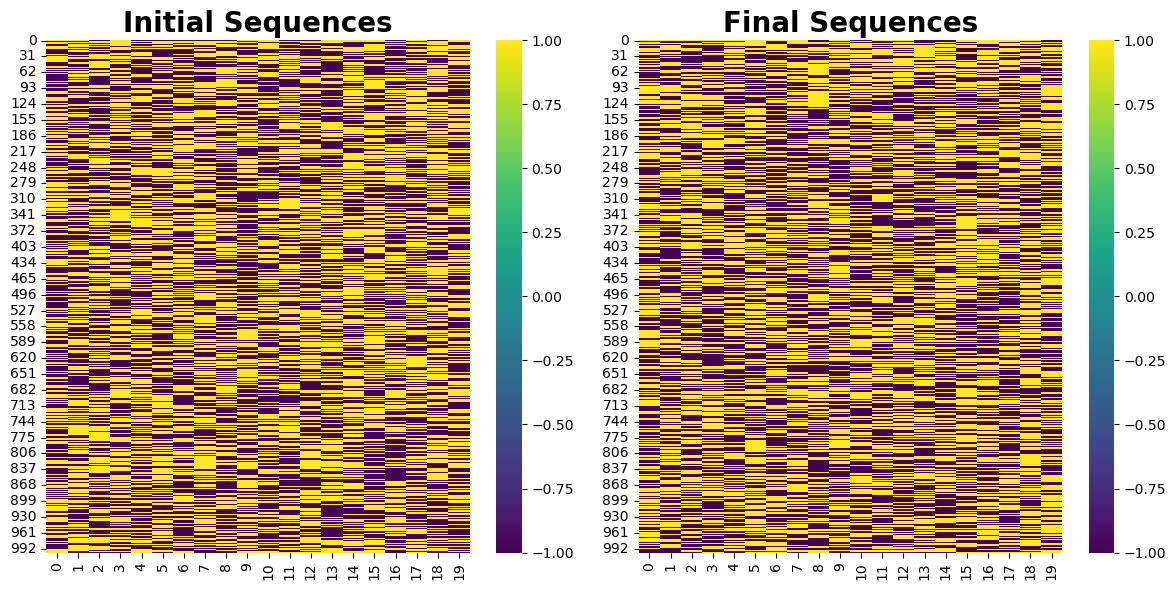

In [47]:
def plotting_heatmaps(initial_sequences, final_chains_train, title1, title2, TP=None):
    # Set up a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Create a heatmap on each subplot
    sns.heatmap(initial_sequences, ax=ax1, cmap='viridis')
    if TP!=None:
        ax1.set_title(title1+f" : TP={TP}", fontweight="bold", size=20)
    else:
        ax1.set_title(title1, fontweight="bold", size=20)

    sns.heatmap(final_chains_train, ax=ax2, cmap='viridis')
    ax2.set_title(title2, fontweight="bold", size=20)

    # Adjust layout
    plt.tight_layout()

    # Display the plot
    plt.show()
plotting_heatmaps(initial_chains, final_chains_train, TP=None, title1="Initial Sequences", title2="Final Sequences")

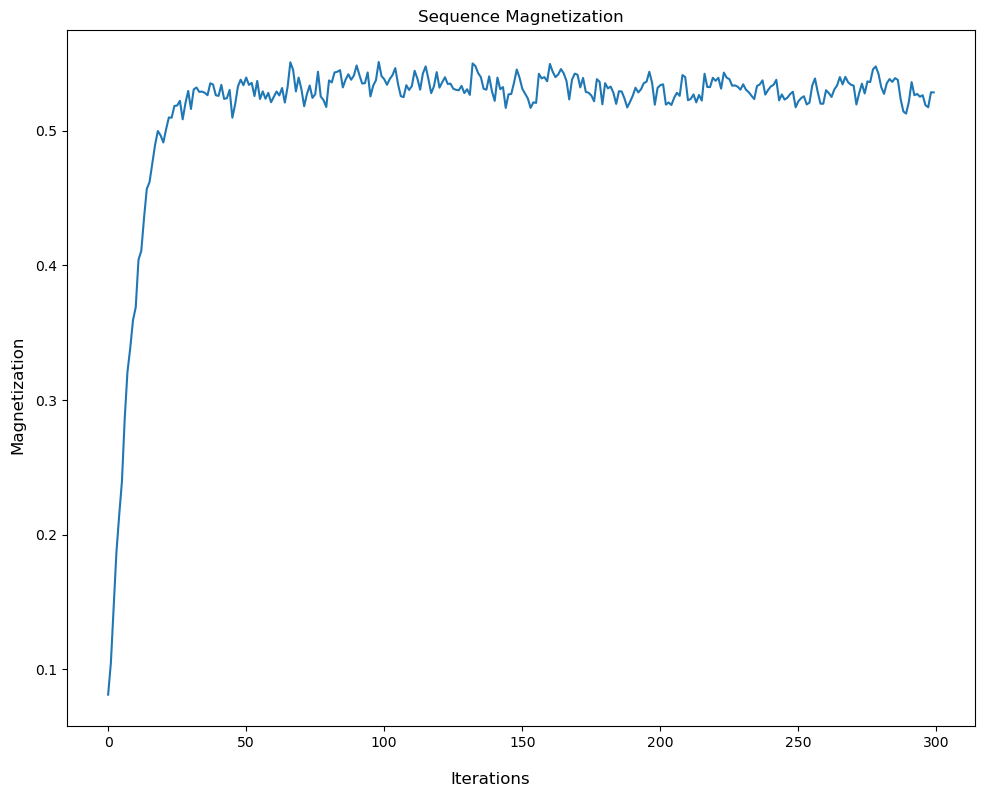

In [5]:
def plotting_magnetization(log_sequences, flip_cluster):
    fig, ax = plt.subplots(1, 1, figsize=(10,8))
    ax.plot(np.arange(flip_cluster), log_sequences.mean(axis=0))
    ax.set_title("Sequence Magnetization")
    fig.supxlabel("Iterations")
    fig.supylabel("Magnetization")
    plt.tight_layout()
    plt.show()
plotting_magnetization(log_sequences, flip_cluster)

100%|██████████| 200/200 [00:00<00:00, 230.82it/s]


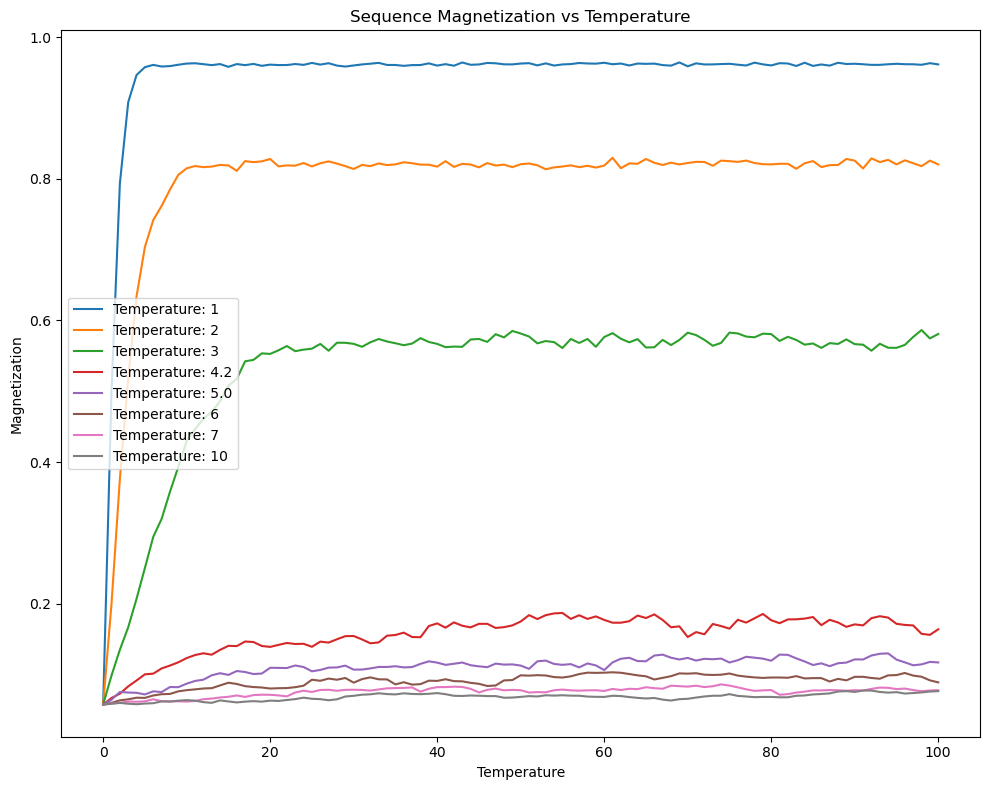

In [274]:
def plot_mag_vs_temp(J, initial_sequences, flip_cluster, temp_list):
    plt.figure(figsize=(10,8))
    for i in range(len(temp_list)):
        __, log_sequences,__ = metropolis_hastings_cluster(J, initial_sequences, flip_cluster=flip_cluster, T=temp_list[i])
        plt.plot(np.arange(flip_cluster+1), log_sequences.mean(axis=0), label=f"Temperature: {temp_list[i]}")
    plt.legend()
    plt.title("Sequence Magnetization vs Temperature")
    plt.xlabel("Temperature")
    plt.ylabel("Magnetization")
    plt.tight_layout()
    plt.show()

num_sequences = 200 # Number of sequences
flip_cluster = 100
J = set_interaction_mat(size, prob=[0.98,0.02])
initial_sequences = [np.random.choice([-1, 1], size=size) for _ in range(num_sequences)]
temp_list = [1, 2, 3, 4.2, 5.0, 6, 7, 10]
plot_mag_vs_temp(J, initial_sequences, flip_cluster, temp_list)

In [231]:
size = 200 # Size of each sequence
num_sequences = 10000 # Number of sequences
flip_cluster = 100
T = 7

J = set_interaction_mat(size, prob=[0.98,0.02])
initial_sequences = [np.random.choice([-1, 1], size=size) for _ in range(num_sequences)]

final_sequences_train, log_sequences, accepted_states = metropolis_hastings_cluster(J, initial_sequences, flip_cluster=flip_cluster, T=T)
final_chains_train = np.array(final_sequences_train)
initial_chains = np.array(initial_sequences)

np.save("data/data_dec_example_big.npy", final_chains_train)
np.save(f'data/contact_mat/J_enc_big.npy', J)

100%|██████████| 10000/10000 [01:39<00:00, 100.36it/s]


In [232]:
# ENCODER DATA GENERATION

size = 20 # Size of each sequence
num_sequences = 1000 # Number of sequences
flip_cluster = 100
temp_list = [1, 2, 3, 4.2, 5.0, 6, 7, 10]
for t in temp_list:
    J = set_interaction_mat(size, prob=[0.7,0.3])
    initial_sequences = [np.random.choice([-1, 1], size=size) for _ in range(num_sequences)]

    final_sequences_train, log_sequences, accepted_states = metropolis_hastings_cluster(J, initial_sequences, flip_cluster=flip_cluster, T=T)
    final_chains_train = np.array(final_sequences_train)
    initial_chains = np.array(initial_sequences)

    np.save(f'data/contact_mat/J_enc_temp={i}.npy', J)
    np.save(f'data/data_enc_big_{i}.npy', final_chains_train)
print("Number of chains:",final_chains_train.shape[0])
print("Number of spins in the chain:",final_chains_train.shape[1])

data_enc_total = np.stack([np.load(f'data/data_enc_big_{i}.npy') for i in range(5)])
print(data_enc_total.shape)

100%|██████████| 10000/10000 [01:43<00:00, 96.20it/s]


Number of chains: 10000
Number of spins in the chain: 200
(5, 10000, 200)


In [208]:
J = np.load("data/contact_mat/J_example_new.npy")
initial_sequences = [np.random.choice([-1, 1], size=size) for _ in range(num_sequences)]

final_sequences_train, log_sequences, accepted_states = metropolis_hastings_cluster(J, initial_sequences, flip_cluster=flip_cluster, T=T)
final_chains_train = np.array(final_sequences_train)
initial_chains = np.array(initial_sequences)

np.save("data/data_enc_example_new_add.npy", final_chains_train)

100%|██████████| 1000/1000 [00:13<00:00, 73.42it/s]


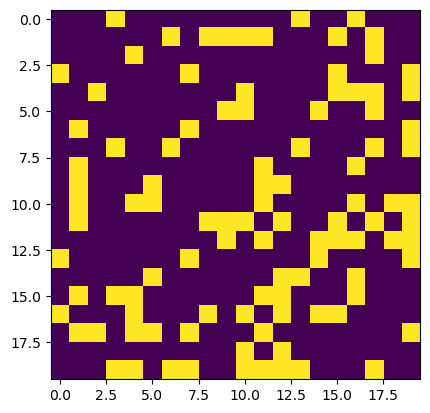

In [207]:
plt.imshow(np.load("data/contact_mat/J_example_new.npy"))

In [187]:
# Save the array to a file
temp = 3 # temperature parameter
np.save("data/contact_mat/J_example_200", J)
np.save(f'data/train_example_200.npy', final_chains_train)
print("Numpy final chains saved!", final_chains_train.shape)

Numpy final chains saved! (1000, 20)


## Covariance matrix

Notes: sometimes covariance does better without inverting

Observation: on real data, covariance does not perform well

In [249]:
J = np.load("data/contact_mat/J_example_new.npy")
final_chains_train = np.load("data/train_example_new.npy")

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1 1 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1]
 [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
 [0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
 [0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 1 0 1]
 [0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 1 1 1 0 1]
 [0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1]
 [0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1]
 [0 1 0 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0 1]
 [0 1 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 0]]


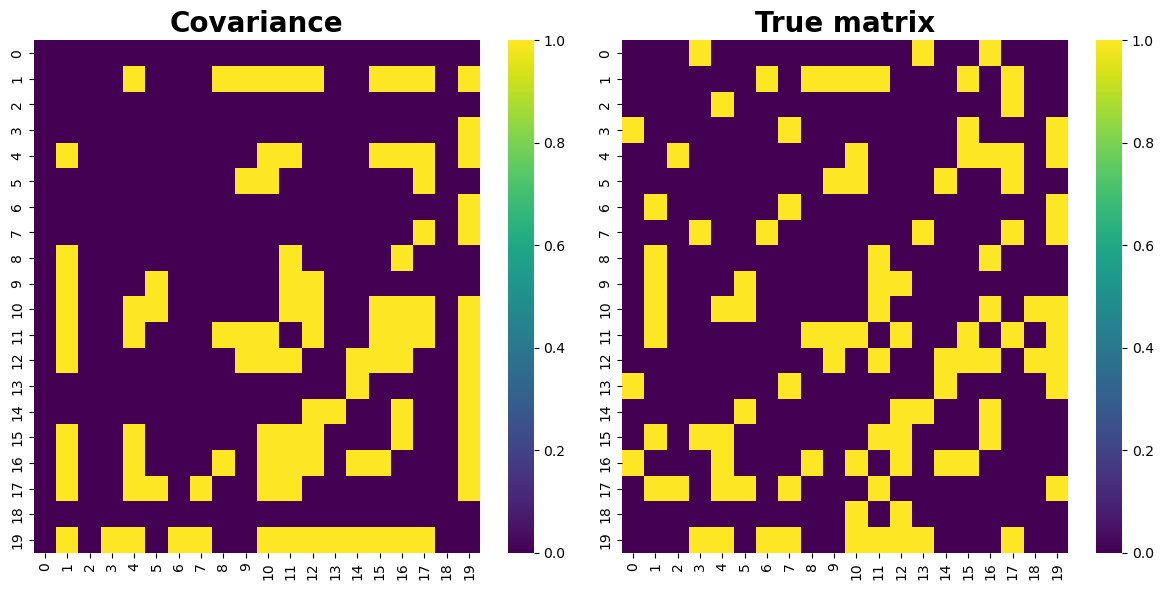

In [250]:
inverted= calc_cov_inv(final_chains_train.copy())[0]

# NORMALISE COVARIANCE MATRIX
# Calculate the 70th percentile
threshold_cov = np.percentile(inverted, 70)
# Apply thresholding: 1 if above threshold, 0 otherwise
inv = np.where(inverted < threshold_cov, 0, 1)
np.fill_diagonal(inv, 0)
plotting_heatmaps(inv, J, title1="Covariance", title2="True matrix")

In [251]:
TP = calculate_true_positives(inv.flatten(), J.flatten())
print("True positives:",TP[0])
print("Accuracy:",TP[1])

FP = calculate_false_positives(inv.flatten(), J.flatten())
print("False positives:",FP[0])
print("Accuracy:",FP[1])

True positives: 76
Accuracy: 0.76
False positives: 24
Accuracy: 0.08053691275167785


## Preliminary metrics for inferring the J coupling matrix
1. Calculates correlation matrix (imported from the authors implementation)
2. Calculates frequencies and coupled frequencies
3. Calculates mutual information. To calculate J, take the inferse of MI

## Mutual Information

<Figure size 800x600 with 0 Axes>

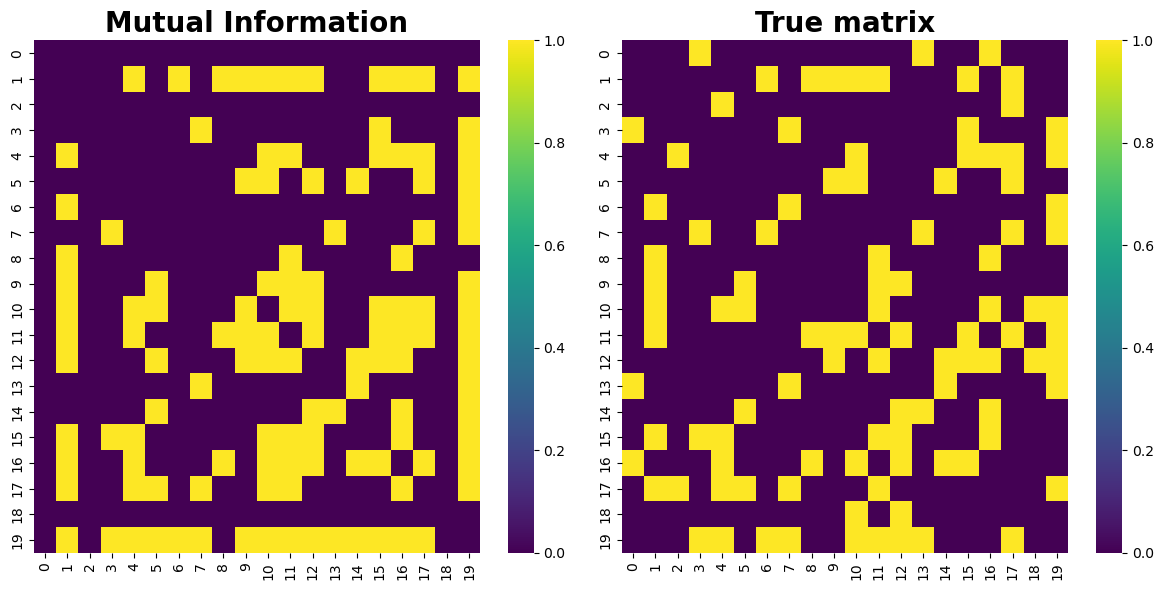

True positives: 86
Accuracy: 0.7166666666666667
False positives: 34
Accuracy: 0.11409395973154363


In [252]:
def calc_mutual_info(final_chains_train):
    mi_matrix = np.zeros((final_chains_train.shape[1], final_chains_train.shape[1]))
    for i in range(final_chains_train.shape[1]):
        for j in range(final_chains_train.shape[1]):
            if i != j:
                mi_matrix[i, j] = mutual_info_score(final_chains_train[:, i], final_chains_train[:, j])
            else:
                mi_matrix[i, j] = 0  # Mutual information of a variable with itself can be ignored or set to 0
    return mi_matrix

mi_matrix = calc_mutual_info(final_chains_train.copy())

# NORMALISE MUTUAL INFORMATION MATRIX
# Plot the mutual information matrix
plt.figure(figsize=(8, 6))
# Calculate the 70th percentile
threshold_mi = np.percentile(mi_matrix, 70)
# Apply thresholding: 1 if above threshold, 0 otherwise
mi_data = np.where(mi_matrix > threshold_mi, 1, 0)
plotting_heatmaps(mi_data, J, title1="Mutual Information", title2="True matrix")

TP = calculate_true_positives(mi_data.flatten(), J.flatten())
print("True positives:",TP[0])
print("Accuracy:",TP[1])

FP = calculate_false_positives(mi_data.flatten(), J.flatten())
print("False positives:",FP[0])
print("Accuracy:",FP[1])

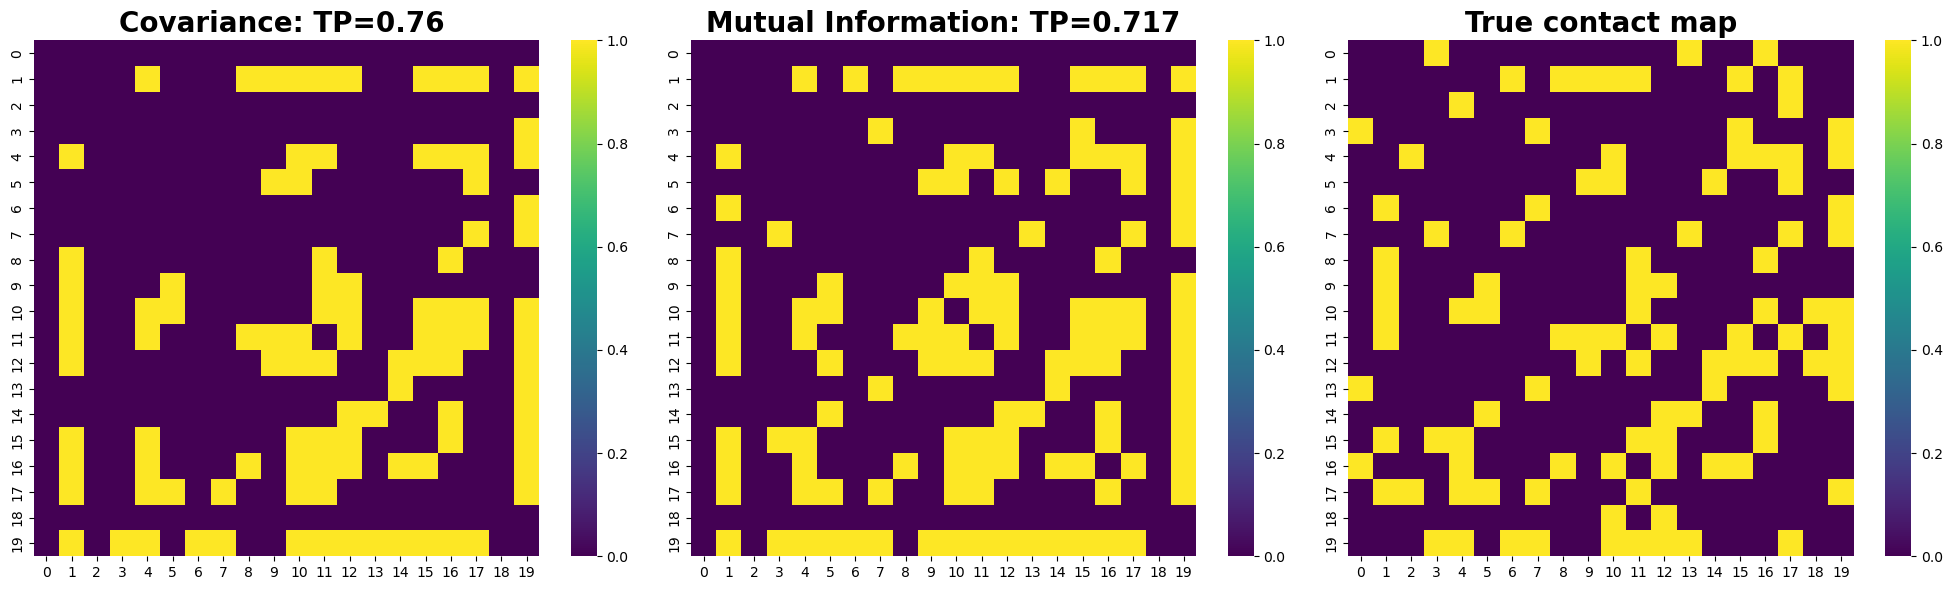

In [253]:
# plot both covariance and mutual information matrices

# Set up a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Create a heatmap on each subplot
sns.heatmap(inv, ax=ax1, cmap='viridis')
ax1.set_title(f"Covariance: TP={round(calculate_true_positives(inv.flatten(), J.flatten())[1],3)} ", fontweight="bold", size=20)

sns.heatmap(mi_data, ax=ax2, cmap='viridis')
ax2.set_title(f"Mutual Information: TP={round(calculate_true_positives(mi_data.flatten(), J.flatten())[1],3)}", fontweight="bold", size=20)

sns.heatmap(J, ax=ax3, cmap='viridis')
ax3.set_title(f"True contact map", fontweight="bold", size=20)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

# Direct Coupling analysis for inferring J

### Mean-field direct coupling analysis (mfDCA)

In [239]:
freqs, cov = compute_frequencies(final_chains_train.T, 2, 0.01)
mfDCAmat = infer_couplings(freqs, cov, 2)
mfDCAmat_frob = compute_frobenius_norm(mfDCAmat)

In [254]:
mfDCAmat_frob = calc_cov_inv(final_chains_train)[1]

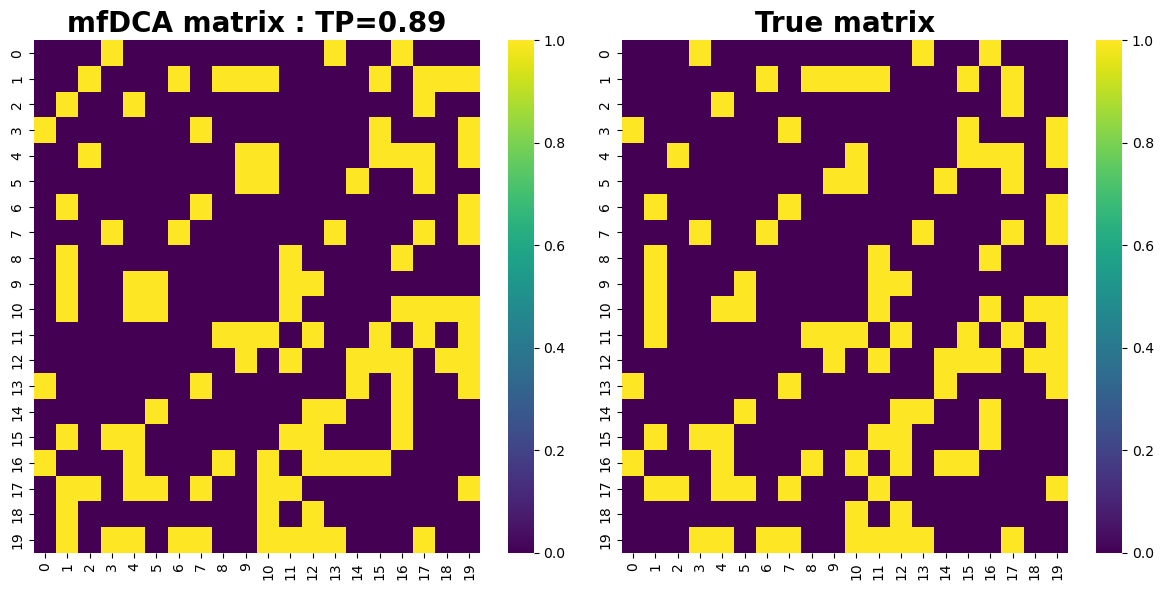

True positives: 100
Accuracy: 0.8928571428571429
False positives: 12
Accuracy: 0.040268456375838924


In [256]:
# NORMALISE MEAN-FIELD DCA MATRIX

# Calculate the 70th percentile
threshold_mf = np.percentile(mfDCAmat_frob, 28)

# Apply thresholding: 1 if above threshold, 0 otherwise
binary_data_mf = np.where(mfDCAmat_frob > threshold_mf, 0, 1)
np.fill_diagonal(binary_data_mf, 0)
#plotting_heatmaps(initial_sequences, final_chains_train, title1, title2, TP=None)
plotting_heatmaps(binary_data_mf, J, TP=np.round(TP[1],2), title1="mfDCA matrix", title2="True matrix")

TP = calculate_true_positives(binary_data_mf.flatten(), J.flatten())
print("True positives:",TP[0])
print("Accuracy:",TP[1])

FP = calculate_false_positives(binary_data_mf.flatten(), J.flatten())
print("False positives:",FP[0])
print("Accuracy:",FP[1])
#plt.imshow(binary_data_mf)
#plt.colorbar()

## Plot for different temperatures

In [262]:
size = 20
num_sequences = 1000

initial_sequences = [np.random.choice([-1, 1], size=size) for _ in range(num_sequences)]
temperature_list = np.linspace(1, 20, 10)
store_final_sequences = []
TP_cov = []
TP_mi = []
TP_mf = []
for t in temperature_list:
    final_sequences_train, log_sequences, accepted_states = metropolis_hastings_cluster(J, initial_sequences, T=t, flip_cluster=100)
    final_chains_train = np.array(final_sequences_train)
    # covariance matrix calculation
    cov_mat = calc_cov_inv(final_chains_train)[0]
    threshold_cov = np.percentile(cov_mat, 70)
    inv = np.where(cov_mat < threshold_cov, 0, 1)  
    TP_cov.append(calculate_true_positives(inv.flatten(), J.flatten()))
    # mutual information calculation
    mi_mat = calc_mutual_info(final_chains_train)
    threshold_mi = np.percentile(mi_mat, 70)
    mi_data = np.where(mi_mat > threshold_mi, 1, 0)
    TP_mi.append(calculate_true_positives(mi_data.flatten(), J.flatten()))
    # mean-field DCA calculation
    #freqs, cov = compute_frequencies(final_chains_train.T, 2, 0.5)
    #mfDCAmat = infer_couplings(freqs, cov, 2)
    #mfDCAmat_frob = compute_frobenius_norm(mfDCAmat)
    mfDCAmat = calc_cov_inv(final_chains_train)[1]
    threshold_mf = np.percentile(mfDCAmat, 30)
    binary_data_mf = np.where(mfDCAmat > threshold_mf, 0, 1)
    np.fill_diagonal(binary_data_mf, 0)
    TP_mf.append(calculate_true_positives(binary_data_mf.flatten(), J.flatten()))
    
    store_final_sequences.append(final_chains_train)
store_final_sequences = np.array(store_final_sequences)
print("Number of different temperatures:",final_chains_train.shape[0])
print("Number of spins in the chain:",final_chains_train.shape[1])

100%|██████████| 1000/1000 [00:04<00:00, 213.36it/s]


Number of different temperatures: 1000
Number of spins in the chain: 20


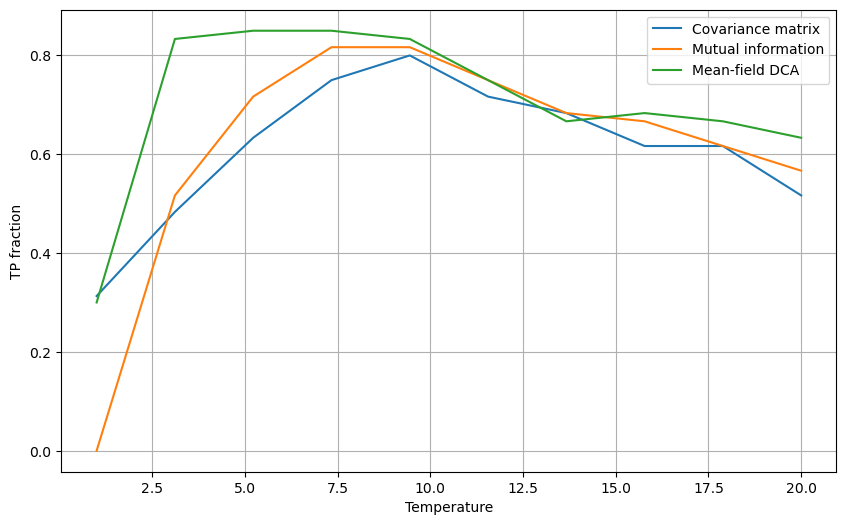

In [263]:
fig = plt.figure(figsize=(10, 6))
plt.plot(temperature_list, [tp[1] for tp in TP_cov], label="Covariance matrix")
plt.plot(temperature_list, [tp[1] for tp in TP_mi], label="Mutual information")
plt.plot(temperature_list, [tp[1] for tp in TP_mf], label="Mean-field DCA")
plt.grid()
plt.xlabel("Temperature")
plt.ylabel("TP fraction")
plt.legend()

## Metropolis-Hastings for sequences with larger vocabulary (20)

In [ ]:
size = 200
num_sequences = 400
choices = np.arange(-10,11)
num_iters = 50
initial_sequences = [np.random.choice(choices, size=size) for _ in range(num_sequences)]
J = set_interaction_mat(size, prob=[0.7,0.3])
final_chains_train, log_sequences, accepted_states = metropolis_hastings_cluster(J, initial_sequences, num_iters=num_iters, T=1.0, num_of_flips=10)
plotting_magnetization(log_sequences,50)

In [ ]:
# Set up a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Create a heatmap on each subplot
sns.heatmap(initial_sequences, ax=ax1, cmap='viridis')
ax1.set_title('Initial Sequences')

sns.heatmap(final_chains_train, ax=ax2, cmap='plasma')
ax2.set_title('Final Sequences')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
initial_sequences = [np.random.choice(choices, size=size) for _ in range(num_sequences)]
final_chains_train, log_sequences, accepted_states = metropolis_hastings_cluster(J, initial_sequences, num_iters=num_iters, T=1.0, num_of_flips=10)
final_chains_train = np.array(final_sequences_train)
initial_chains = np.array(initial_sequences)
np.save(f'final_chains_T={temp}_num_iters={num_iters}_test_large.npy', final_chains_train)